In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure
from mejiro.plots import plot_util
from mejiro.engines import webbpsf_engine, galsim_engine

Computing on pixel grid of size 47x47 (5.17"x5.17") with pixel scale 0.11 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 1)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


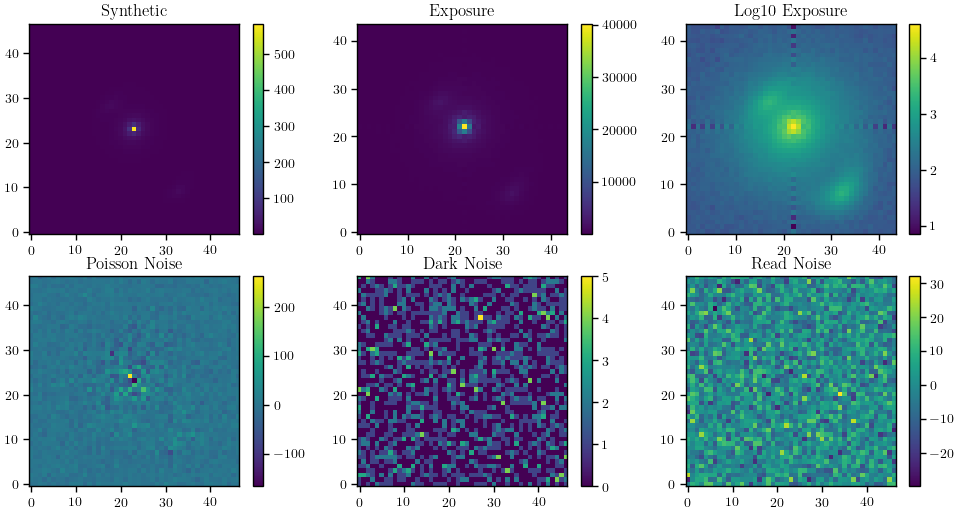

In [2]:
lens = SampleStrongLens()
roman = Roman()
band = 'F106'
scene_size = 5  # arcsec
oversample = 1
exposure_time = 146
instrument_params = {
    'detector': 1,
    'detector_position': (2048, 2048)
}

synth = SyntheticImage(lens, roman, band, arcsec=scene_size, oversample=oversample, pieces=False, verbose=True, instrument_params=instrument_params)
# psf = np.load('/grad/bwedig/mejiro/tests/test_data/F106_1_2048_2048_1_47.npy')
gsparams_kwargs = {
    # 'folding_threshold': 1e-10,
}
exposure = Exposure(synth, exposure_time=exposure_time, engine='galsim', psf=None, verbose=True, gsparams_kwargs=gsparams_kwargs)

_, ax = plt.subplots(2, 3, figsize=(12, 6))
ax00 = ax[0,0].imshow(synth.image)
ax01 = ax[0,1].imshow(exposure.exposure)
ax02 = ax[0,2].imshow(np.log10(exposure.exposure))
ax10 = ax[1,0].imshow(exposure.poisson_noise.array)
ax11 = ax[1,1].imshow(exposure.dark_noise.array)
ax12 = ax[1,2].imshow(exposure.read_noise.array)
plt.colorbar(ax00, ax=ax[0,0])
plt.colorbar(ax01, ax=ax[0,1])
plt.colorbar(ax02, ax=ax[0,2])
plt.colorbar(ax10, ax=ax[1,0])
plt.colorbar(ax11, ax=ax[1,1])
plt.colorbar(ax12, ax=ax[1,2])
ax[0,0].set_title('Synthetic')
ax[0,1].set_title('Exposure')
ax[0,2].set_title('Log10 Exposure')
ax[1,0].set_title('Poisson Noise')
ax[1,1].set_title('Dark Noise')
ax[1,2].set_title('Read Noise')
plt.show()

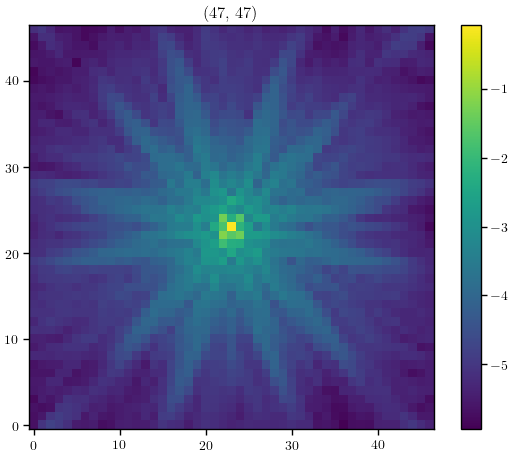

In [3]:
plt.imshow(np.log10(exposure.psf))
plt.colorbar()
plt.title(exposure.psf.shape)
plt.show()

In [4]:
psf_fwhm = roman.get_psf_fwhm(band)
print(f'PSF FWHM: {psf_fwhm} arcsec or {psf_fwhm / 0.11:.2f} pixels')

print(f'Make PSF 40-80 times FWHM, so {40*psf_fwhm / 0.11:.2f} to {80*psf_fwhm / 0.11:.2f} pixels')

PSF FWHM: 0.087 arcsec or 0.79 pixels
Make PSF 40-80 times FWHM, so 31.64 to 63.27 pixels


In [5]:
from astropy.convolution import Gaussian2DKernel
gaussian_2D_kernel = Gaussian2DKernel(10)

In [6]:
# engine_params = {
#     'sky_background': False,
#     'detector_effects': False
# }

# num_pix_1 = 100
# synth_1 = deepcopy(synth)
# psf_1 = webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_1, verbose=True)
# exposure_1 = Exposure(synth_1, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_1, verbose=True)

# synth_2 = deepcopy(synth)
# psf_2 = gaussian_2D_kernel
# exposure_2 = Exposure(synth_2, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_2, verbose=True)

# residual = exposure_1.exposure - exposure_2.exposure
# v = plot_util.get_v(residual)
# _, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax[0].imshow(np.log10(exposure_1.exposure))
# ax[1].imshow(np.log10(exposure_2.exposure))
# ax2 = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)
# plt.colorbar(ax2, ax=ax[2])
# plt.show()

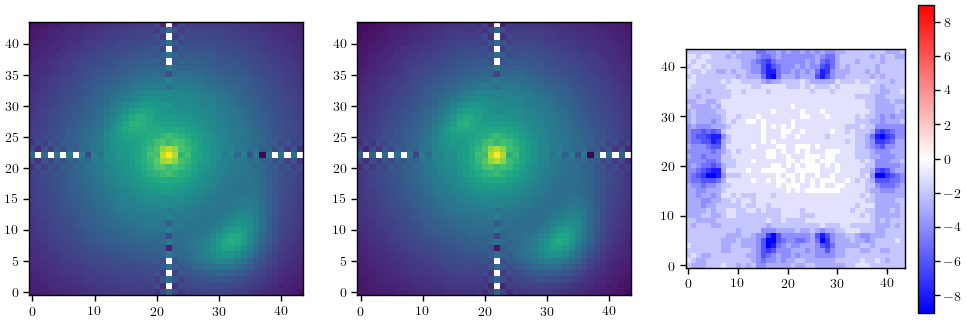

In [7]:
engine_params = {
    'sky_background': False,
    'detector_effects': False
}

num_pix_1 = 31
synth_1 = deepcopy(synth)
psf_1 = webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_1, verbose=True)
exposure_1 = Exposure(synth_1, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_1, verbose=True)

num_pix_2 = 91
synth_2 = deepcopy(synth)
psf_2 =  webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_2, verbose=True)
exposure_2 = Exposure(synth_2, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_2, verbose=True)

residual = exposure_1.exposure - exposure_2.exposure
v = plot_util.get_v(residual)
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.log10(exposure_1.exposure))
ax[1].imshow(np.log10(exposure_2.exposure))
ax2 = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar(ax2, ax=ax[2])
plt.show()

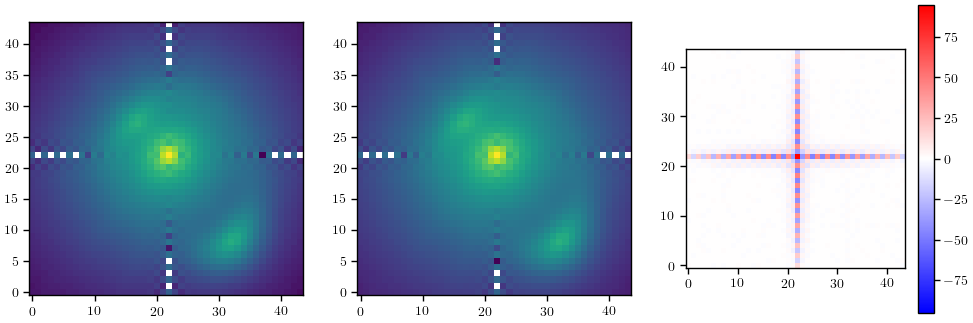

In [8]:
engine_params = {
    'sky_background': False,
    'detector_effects': False
}

num_pix_1 = 91
synth_1 = deepcopy(synth)
psf_1 = webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_1, verbose=True)
exposure_1 = Exposure(synth_1, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_1, verbose=True)

num_pix_2 = 1001
synth_2 = deepcopy(synth)
psf_2 =  webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_2, verbose=True)
exposure_2 = Exposure(synth_2, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_2, verbose=True)

residual = exposure_1.exposure - exposure_2.exposure
v = plot_util.get_v(residual)
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.log10(exposure_1.exposure))
ax[1].imshow(np.log10(exposure_2.exposure))
ax2 = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar(ax2, ax=ax[2])
plt.show()

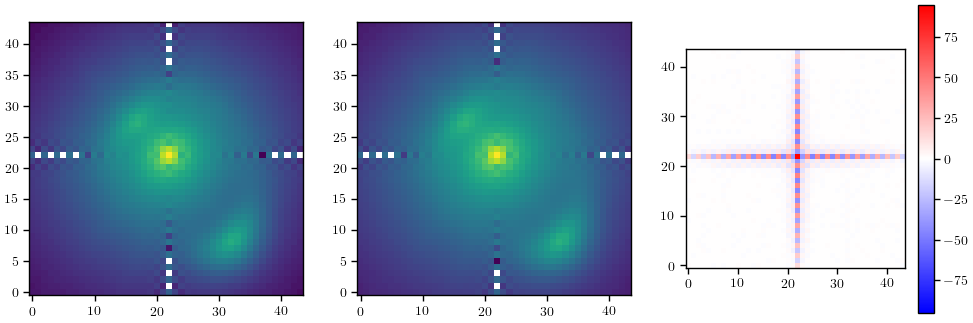

In [9]:
engine_params = {
    'sky_background': False,
    'detector_effects': False
}

num_pix_1 = 201
synth_1 = deepcopy(synth)
psf_1 = webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_1, verbose=True)
exposure_1 = Exposure(synth_1, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_1, verbose=True)

num_pix_2 = 1001
synth_2 = deepcopy(synth)
psf_2 =  webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_2, verbose=True)
exposure_2 = Exposure(synth_2, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_2, verbose=True)

residual = exposure_1.exposure - exposure_2.exposure
v = plot_util.get_v(residual)
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.log10(exposure_1.exposure))
ax[1].imshow(np.log10(exposure_2.exposure))
ax2 = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar(ax2, ax=ax[2])
plt.show()

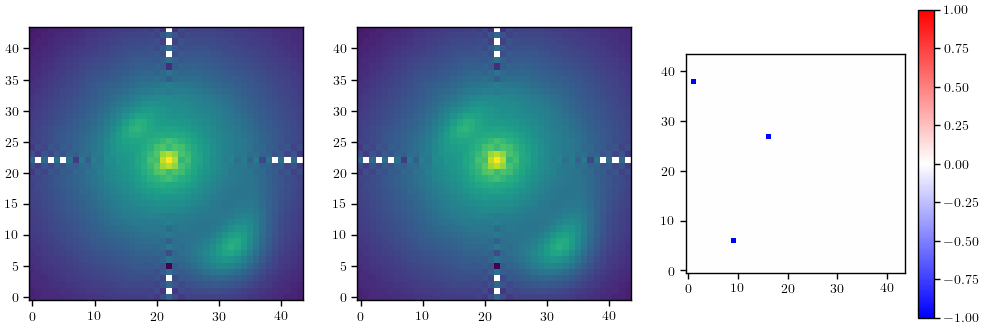

In [10]:
engine_params = {
    'sky_background': False,
    'detector_effects': False
}

num_pix_1 = 501
synth_1 = deepcopy(synth)
psf_1 = webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_1, verbose=True)
exposure_1 = Exposure(synth_1, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_1, verbose=True)

num_pix_2 = 1001
synth_2 = deepcopy(synth)
psf_2 =  webbpsf_engine.get_roman_psf(band, instrument_params['detector'], instrument_params['detector_position'], oversample, num_pix_2, verbose=True)
exposure_2 = Exposure(synth_2, exposure_time=exposure_time, engine='galsim', engine_params=engine_params, psf=psf_2, verbose=True)

residual = exposure_1.exposure - exposure_2.exposure
v = plot_util.get_v(residual)
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.log10(exposure_1.exposure))
ax[1].imshow(np.log10(exposure_2.exposure))
ax2 = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar(ax2, ax=ax[2])
plt.show()